In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from scipy import stats as ss

In [22]:
df = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [23]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

# Feature Transformation & Engineering

First step will be to transform our columns and determine best features for model. We can start by looking at the boxplot for percentage of values missing in a column to determine a good cutoff. 

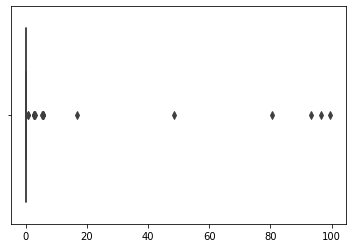

In [25]:
sns.boxplot(df.isnull().sum()/len(df)*100)

In [26]:
print('Average % Missing Values Per Column:')
(df.isnull().sum()/len(df)*100).mean()

Average % Missing Values Per Column:


5.8257720802463995

Looks like most columns are missing less than twenty percent of their values. Let's write a function that rids us of columns missing more than that.

In [27]:
def drop_missing(df):
    dataframe = df.copy()
    cutoff = 0.2 * len(dataframe)
    for col in dataframe:
        if dataframe[col].isnull().sum() >= cutoff:
            print(col)
            dataframe = dataframe.drop(columns=[col])
    return dataframe

In [28]:
print("Dropped because of too many missing values:")
clean_df = drop_missing(df)

Dropped because of too many missing values:
Alley
Fireplace Qu
Pool QC
Fence
Misc Feature


How does the boxplot of % missing values in a column look now?

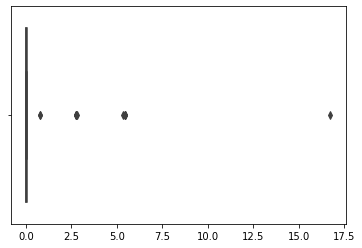

In [29]:
sns.boxplot(clean_df.isnull().sum()/len(clean_df)*100)

In [30]:
print('Average % Missing Values Per Column:')
(clean_df.isnull().sum()/len(clean_df)*100).mean()

Average % Missing Values Per Column:


0.7730153805239128

So which columns are we left with?

In [31]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 77 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2

Since we know we're going to be doing a linear regression, we also want to get rid of any columns that aren't particularly informative. Specifically, we're going to drop columns where the vast majority of values within the column are the same.

In [32]:
#drops columns from clean_df where >98% of values are the same and prints list of dropped columns.
print('Columns Dropped Due to High Homogeneity:')
for col in clean_df:
    if (clean_df[col].value_counts(normalize=True)*100).sort_values(ascending=False).iloc[0] > 98:
        clean_df = clean_df.drop(columns=[col])
        print(col)

Columns Dropped Due to High Homogeneity:
Street
Utilities
Condition 2
Roof Matl
Heating
Low Qual Fin SF
3Ssn Porch
Pool Area


And here's what's left.

In [33]:
clean_df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Lot Shape', 'Land Contour', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Functional', 'Fireplaces', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Ope

To get more info, we'll need to dive into some of these columns. Starting from the top, I know that "Order" and "PID" are unnecessary identifiers. From the documentation, I know that "MS SubClass" is actually categorical, but coded using numbers. "Overall Quality" and "Overall Condition" are ordinal, so for the sake of our regression, we'll need to convert them to categorical variables as well, since we don't know anything about the distances between our ranks. "Yr Sold" and "Mo Sold" should also be converted to categorical variables, since they're unlikely to vary with "SalePrice" in a linear fashion. 

In [34]:
clean_df = clean_df.drop(columns=['Order', 'PID'])
for col in ['MS SubClass', 'Overall Qual', 'Overall Cond', 'Yr Sold', 'Mo Sold']:
    clean_df[col] = clean_df[col].astype(str)

We'll need to impute any missing values in our numerical variables. The best imputation method will depend on our distribution for each variable. So, we'll write a function that gives us the distribution plots for each numerical variable with missing values.

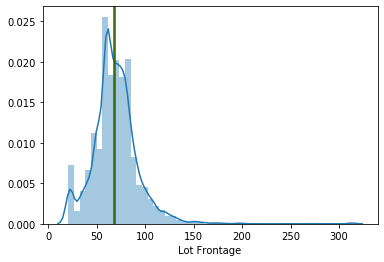

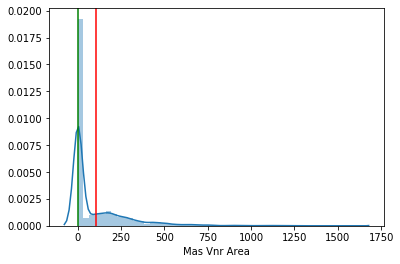

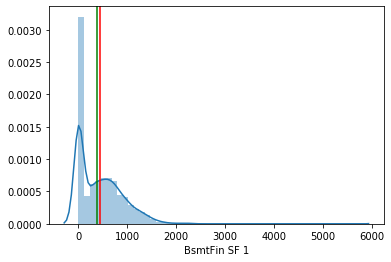

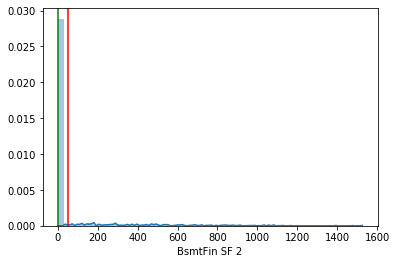

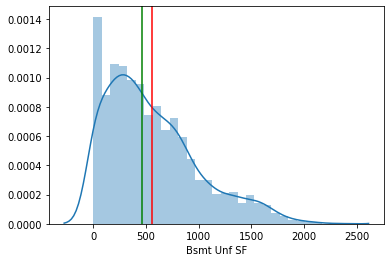

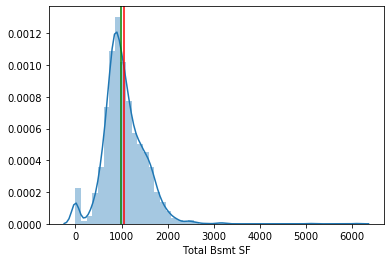

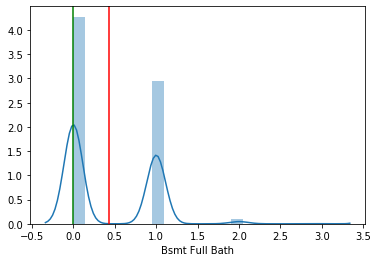

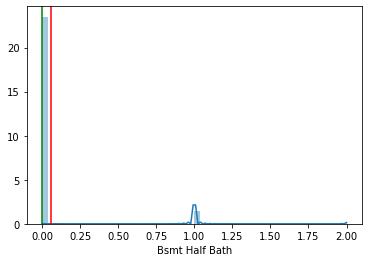

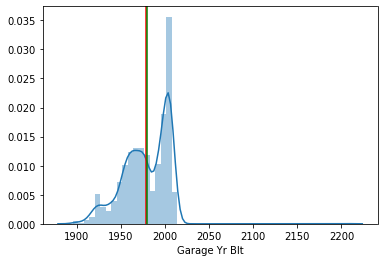

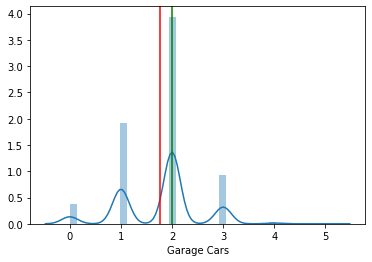

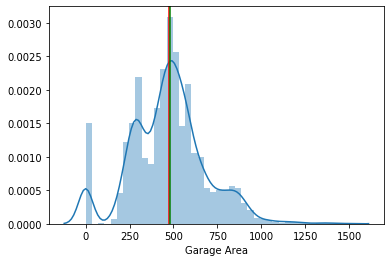

In [35]:
def distplot_for_imputation(dataframe):
    for i,col in enumerate(dataframe.select_dtypes(include=['integer', 'float'])):
        if dataframe[col].isnull().sum() > 0:
            plt.figure(i)
            ax = sns.distplot(dataframe[col].dropna())
            ax.axvline(dataframe[col].mean(), c='red')
            ax.axvline(dataframe[col].median(), c='green')
            
distplot_for_imputation(clean_df)

For simplicity's sake, I'll be sticking with imputation using either the mean or median for each column. From the above distplots, we can see which is more appropriate for each variable. I'll be using the mean for "Lot Frontage", "BsmtFin SF 1", "Garage Yr Blt", and "Garage Area", and the median for "Mas Vnr Area", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "Bsmt Full Bath", "Bsmt Half Bath", and "Garage Cars".

In [36]:
def impute_with_means(dataframe, cols_list):
    for col in cols_list:
        dataframe[col] = dataframe[col].fillna(dataframe[col].mean())

cols_for_mean_imputation = ["Lot Frontage", "BsmtFin SF 1", "Garage Yr Blt", "Garage Area"]

impute_with_means(clean_df, cols_for_mean_imputation)

In [37]:
def impute_with_medians(dataframe, cols_list):
    for col in cols_list:
        dataframe[col] = dataframe[col].fillna(dataframe[col].median())

cols_for_median_imputation = ["Mas Vnr Area", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "Bsmt Full Bath", "Bsmt Half Bath", "Garage Cars"]

impute_with_medians(clean_df, cols_for_median_imputation)

Some columns seem to contain significantly overlapping information. For example, "Land Contour" and "Land Slope" (though we will test if this is the case with Cramer's V), "Gr Liv Area" and "TotRms AbvGrd", "Garage Cars" and "Garage Area", and "MS SubClass" and "House Style". We can either combine or drop one of these in each pairing.

In [38]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers_v(clean_df['Land Slope'], clean_df['Land Contour'])

0.43667872822477694

"Land Contour" and "Land Slope" are significantly less correlated than I expected them to be. We'll keep both. "MS SubClass" is basically a combination of "Yr Sold" and "House Style", so we don't need it. We know that "Gr Liv Area" contains more info than "TotRms AbvGrd", and "Garage Area" contains more info than "Garage Cars". Let's drop the less informative columns. Before we drop "TotRms AbvGrd," however, I want to use it to engineer a feature "Avg Rm Area AbvGrd." Given the popularity of open floorplans, there's a possibility that larger rooms are linked with higher prices.

In [39]:
clean_df['Avg Rm Area AbvGrd'] = clean_df['Gr Liv Area']/clean_df['TotRms AbvGrd']
clean_df = clean_df.drop(columns=['TotRms AbvGrd', 'Garage Cars', 'MS SubClass'])

Some interesting information is contained in "Condition 1", like adjacency to railroads and arterial streets. We might want to collapse some of these categories, though. For example, the dataframe has seperate categories for adjacent vs. "near" (within 200'), and well as separate categories for "north-south" vs. "east-west" railroads. I doubt these distinctions matter when it comes to sales price, but let's look at the boxplots.

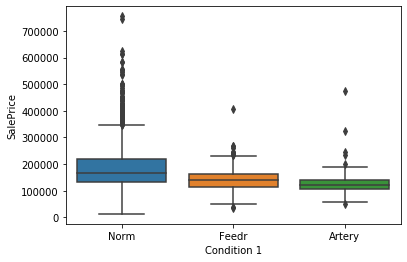

In [40]:
near_busy_rds = clean_df[(clean_df['Condition 1']=='Artery') | (clean_df['Condition 1']=='Feedr') | (clean_df['Condition 1']=='Norm')]
sns.boxplot(y=near_busy_rds['SalePrice'], x=near_busy_rds['Condition 1'])

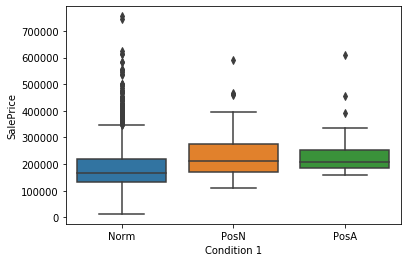

In [41]:
near_positives = clean_df[(clean_df['Condition 1']=='Norm') | (clean_df['Condition 1']=='PosN') | (clean_df['Condition 1']=='PosA')]
sns.boxplot(y=near_positives['SalePrice'], x=near_positives['Condition 1'])

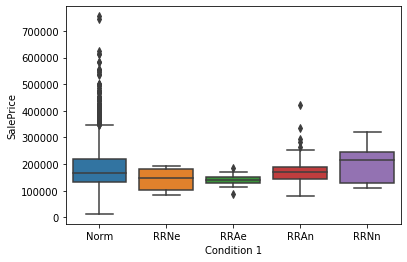

In [42]:
near_railrds = clean_df[(clean_df['Condition 1'] == 'Norm') | (clean_df['Condition 1']=='RRNn') | (clean_df['Condition 1']=='RRAn') | (clean_df['Condition 1']=='RRNe') | (clean_df['Condition 1']=='RRAe')]
sns.boxplot(y=near_railrds['SalePrice'], x=near_railrds['Condition 1'])

While I think a compelling case can be made for grouping "Feedr" and "Artery" (which indicate if a property is on a busy street or a busier street), as well as "PosN" and "PosA" (which indicate whether the property is near or directly adjacent to something positive, such as a park), the boxplots for our railroad values don't support the idea of collapsing these categories. Intuitively, being directly adjacent to a railroad vs. up to 200' away from a railroad does seem like a significantly different kind of living situation. What if we just collapse the railroad direction?

In [43]:
clean_df['Condition 1'] = clean_df['Condition 1'].apply(
    lambda x: 'RRA' if (x == 'RRAe' or x == 'RRAn') 
    else ('RRN' if (x == 'RRNe' or x == 'RRNn') else x))

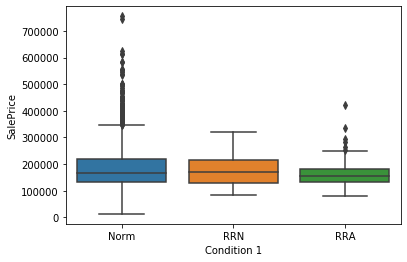

In [44]:
near_railrds = clean_df[(clean_df['Condition 1'] == 'Norm') | (clean_df['Condition 1']=='RRN') | (clean_df['Condition 1']=='RRA')]
sns.boxplot(y=near_railrds['SalePrice'], x=near_railrds['Condition 1'])

We can see that being near (within 200' of a railroad) is more like the norm than being directly adjacent to a railroad in the above boxplot. So, let's collapse our categories down to: railroad adjacent (RRA), near railroad (RRN), near or adacent to positives (PosNA), on a feeder or arterial st (BusyRd), and Norm. 

In [45]:
clean_df['Condition 1'] = clean_df['Condition 1'].map({
    'RRA': 'RRA',
    'RRN': 'RRN',
    'PosN': 'PosNA',
    'PosA': 'PosNA',
    'Feedr': 'BusyRd',
    'Artery': 'BusyRd',
    'Norm': 'Norm'
})

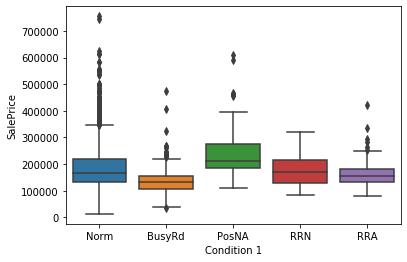

In [46]:
sns.boxplot(x=clean_df['Condition 1'], y=clean_df['SalePrice'])

"Year Built" might give some idea of the architectural style of the house, but the more important information it contains is the age of the house at sale. Similarly, "Year Remod/Add" is probably more useful to us as age, as is "Garage Yr Blt".

In [49]:
clean_df['Sale Age'] = clean_df['Yr Sold'].astype(int) - clean_df['Year Built']
clean_df['Sale Remod/Add Age'] = clean_df['Yr Sold'].astype(int) - clean_df['Year Remod/Add']
clean_df['Sale Garage Age'] = clean_df['Yr Sold'].astype(int) - clean_df['Garage Yr Blt']
clean_df.drop(columns = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt'], inplace=True)

"Exterior 1st" and "Exterior 2nd" won't dummy code correctly the way that they are currently categorized. We'll need to replace all the "Exterior 2nd" values that are the same as the "Exterior 1st" values with NaN. But first, we'll need to make sure they have consistent strings. Then we'll do the same with "BsmtFin Type 1" and "BsmtFin Type 2".

In [50]:
clean_df['Exterior 1st'] = clean_df['Exterior 1st'].map({
    'AsbShng': 'AsbShng',
    'AsphShn': 'AsphShn',
    'BrkComm': 'Brk Cmn',
    'BrkFace': 'BrkFace',
    'CBlock': 'CBlock',
    'CemntBd': 'CmentBd',
    'HdBoard': 'HdBoard',
    'ImStucc': 'ImStucc',
    'MetalSd': 'MetalSd',
    'Other': 'Other',
    'Plywood': 'Plywood',
    'PreCast': 'PreCast',
    'Stone': 'Stone',
    'Stucco': 'Stucco',
    'VinylSd': 'VinylSd',
    'Wd Sdng': 'Wd Sdng',
    'WdShing': 'Wd Shng'
})
for index,row in clean_df.iterrows():
    if row['Exterior 1st'] == row['Exterior 2nd']:
        clean_df.loc[index,'Exterior 2nd'] = np.nan

In [51]:
clean_df['Exterior 1st'].value_counts(dropna=False)

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     420
Plywood     221
CmentBd     126
BrkFace      88
Wd Shng      56
AsbShng      44
Stucco       43
Brk Cmn       6
CBlock        2
Stone         2
AsphShn       2
PreCast       1
ImStucc       1
Name: Exterior 1st, dtype: int64

In [52]:
clean_df['Exterior 2nd'].value_counts(dropna=False)

NaN        2657
Plywood      88
Wd Shng      40
Wd Sdng      39
HdBoard      23
Brk Cmn      18
Stucco       14
ImStucc      14
MetalSd      10
VinylSd       9
Stone         5
AsbShng       3
BrkFace       3
CBlock        2
AsphShn       2
CmentBd       2
Other         1
Name: Exterior 2nd, dtype: int64

In [53]:
for index,row in clean_df.iterrows():
    if row['BsmtFin Type 1'] == row['BsmtFin Type 2']:
        clean_df.loc[index,'BsmtFin Type 2'] = np.nan

In [54]:
clean_df['BsmtFin Type 2'].value_counts(dropna=False)

Unf    1648
NaN     933
Rec     106
LwQ      89
BLQ      67
ALQ      53
GLQ      34
Name: BsmtFin Type 2, dtype: int64

Now we'll dummy-code both of these categories separately to ensure they code correctly.

In [55]:
#creates one column that combines the two related cols
clean_df['All Exteriors'] = 'All Exteriors_' + clean_df['Exterior 2nd'] + '|' + 'All Exteriors_' + clean_df['Exterior 1st']
clean_df['All BsmtFin Types'] = 'All BsmtFin Types_' + clean_df['BsmtFin Type 1'] + '|' + 'All BsmtFin Types_' + clean_df['BsmtFin Type 2']
#imputes the combined col with its mode
clean_df['All Exteriors'] = clean_df['All Exteriors'].fillna(clean_df['All Exteriors'].mode())
clean_df['All BsmtFin Types'] = clean_df['All BsmtFin Types'].fillna(clean_df['All BsmtFin Types'].mode())
#dummy-codes the combined col
clean_df = pd.concat([clean_df,clean_df['All Exteriors'].str.get_dummies()], axis=1)
clean_df = pd.concat([clean_df,clean_df['All BsmtFin Types'].str.get_dummies()], axis=1)
#drops the now irrelevant cols
clean_df.drop(columns=['All Exteriors', 'All BsmtFin Types', 'Exterior 1st', 'Exterior 2nd', 'BsmtFin Type 1', 'BsmtFin Type 2', 'All Exteriors_Other'], inplace=True)

Since "Central Air" only has two options (Y or N), we can go ahead and code it as 1 and 0.

In [56]:
clean_df['Central Air'] = clean_df['Central Air'].map({'Y':1, 'N':0})

I don't think "Half Bath" is useful to us on its own. While buyers might decide based on the number of Full Baths, or bathrooms generally, it seems unlikely that the number of half baths is weighing heavily in their decision. Let's combine it with "Full Bath", "Bsmt Full Bath", and "Bsmt Half Bath" to make a "Bathrooms" column.

In [57]:
clean_df['Bathrooms'] = clean_df['Full Bath'] + clean_df['Half Bath'] + clean_df['Bsmt Full Bath'] + clean_df['Bsmt Half Bath']

Finally, we might want to limit ourselves to normal sales. The "Sale Condition" column tells us if a sale was between family members, partial, at auction, etc. Abnormal sales conditions would likely lead to abnormal sales.

In [58]:
clean_df = clean_df[clean_df['Sale Condition']=='Normal']
clean_df.drop(columns=['Sale Condition'], inplace=True)

And we'll need to impute our categorical variables with their modes.

In [59]:
def impute_with_modes(dataframe, cols_list):
    for col in cols_list:
        dataframe[col] = dataframe[col].fillna(dataframe[col].mode())

cols_for_mode_imputation = clean_df.select_dtypes(include='object').columns
impute_with_modes(clean_df, cols_for_mode_imputation)

Now we can dummy code our string variables.

In [60]:
dummied_df = pd.get_dummies(clean_df, columns=clean_df.select_dtypes(include='object').columns)


# Feature Selection

To select our features, we first need to eliminate overlap. We can do this by looking at correlations in our data set and making sure highly correlated variables are not conveying the same info.

In [61]:
for col in dummied_df:
    for col2 in dummied_df:
        if col != col2:
            if abs(dummied_df[col].corr(dummied_df[col2])) >= 0.75:
                print(col +': '+ col2 + ", r = " + str(dummied_df[col].corr(dummied_df[col2])))
   

Total Bsmt SF: 1st Flr SF, r = 0.7665653654934246
1st Flr SF: Total Bsmt SF, r = 0.7665653654934246
2nd Flr SF: House Style_1Story, r = -0.7886628414835067
2nd Flr SF: House Style_2Story, r = 0.8003498623055502
Kitchen AbvGr: Bldg Type_Duplex, r = 0.7693571969888975
Sale Age: Sale Garage Age, r = 0.7812075490119335
Sale Garage Age: Sale Age, r = 0.7812075490119336
All Exteriors_Brk Cmn: Neighborhood_NPkVill, r = 0.8568807304411044
MS Zoning_FV: Neighborhood_Somerst, r = 0.8940738719298348
MS Zoning_RL: MS Zoning_RM, r = -0.840795665939288
MS Zoning_RM: MS Zoning_RL, r = -0.8407956659392881
Lot Shape_IR1: Lot Shape_Reg, r = -0.9321259011808267
Lot Shape_Reg: Lot Shape_IR1, r = -0.9321259011808266
Land Slope_Gtl: Land Slope_Mod, r = -0.9495594196889672
Land Slope_Mod: Land Slope_Gtl, r = -0.9495594196889672
Neighborhood_NPkVill: All Exteriors_Brk Cmn, r = 0.8568807304411044
Neighborhood_Somerst: MS Zoning_FV, r = 0.8940738719298347
Condition 1_BusyRd: Condition 1_Norm, r = -0.77096262914

From our function, we can see that "Total Bsmt SF" is strongly correlated with "1st Flr SF". Since the 1st floor SF is included in our "Gr Liv Area", we can go ahead and drop this column. 

In [62]:
dummied_df.drop(columns=['1st Flr SF'], inplace=True)

The next correlations that seem high are with "House Style_1Story" and "House Style_2Story." Neither category is giving us information that "2nd Flr SF" wasn't already giving us, and with much less detail. We'll drop these.

In [63]:
dummied_df.drop(columns =['House Style_1Story', 'House Style_2Story'], inplace=True)

"Bldg Type_Duplex" shows a high amount of correlation with "Kitchen AbvGr", but they convey separate pieces of information. This likely results from duplexes commonly having 2 kitchens. We'll keep both columns.

In [64]:
clean_df[clean_df['Bldg Type']=='Duplex']['Kitchen AbvGr'].head(30)

83     2
135    2
138    2
158    2
205    1
216    2
217    2
225    1
275    2
290    2
294    2
313    2
324    2
336    2
392    2
551    2
622    2
641    2
666    2
669    2
676    2
678    2
688    1
694    2
701    2
764    2
815    2
816    2
817    2
899    2
Name: Kitchen AbvGr, dtype: int64

"Sale Age" and "Sale Garage Age" are highly correlated. Likely, this is because many houses were built with garages, and the garage is thus the same age as the house. It's unlikely the age of the garage has an impact on "SalePrice" beyond its correlation with "Sale Age", but we can check this by looking at rows where the "Sale Age" is different from the "Sale Garage Age."

In [65]:
house_age_not_garage_age = dummied_df[dummied_df['Sale Age']!=dummied_df['Sale Garage Age']]
print('r = ' + str(house_age_not_garage_age['SalePrice'].corr(house_age_not_garage_age['Sale Garage Age'])))

r = -0.2611086173912688


If we rule out rows where "Sale Garage Age" is the same as "Sale Age", then we find only a weak correlation between "Sale Garage Age" and "SalePrice." Still, we may want to keep both for now.

A brick common exterior is correlated with the Northpark Village neighborhood, but that likely is just a function of neighborhood style. No need to do anything about this. 

The next three high correlations we have are with "MS Zoning" categories. The first being between a "FV" (floating village) zoning and the neighborhood of Somerset, and the next two being between two different "MS Zoning" categories. The latter two are the result of the majority of houses being either zoned as low or medium density residential, such that a 1 in one column likely meant a 0 in the other and vice versa. But let's take a closer look at the first correlation, between Somerset and floating village zoning. 

In [66]:
#gives us the counts of the values of our Somerset column when our FV column is 1
dummied_df[dummied_df['MS Zoning_FV']==1]['Neighborhood_Somerst'].value_counts()

1    92
Name: Neighborhood_Somerst, dtype: int64

In [67]:
#gives us the counts of the values of our FV column when our Somerset column is 1
dummied_df[dummied_df['Neighborhood_Somerst']==1]['MS Zoning_FV'].value_counts()

1    92
0    22
Name: MS Zoning_FV, dtype: int64

So, all instances of "floating village" zoning are within the Somerset neighborhood, and all but 22 houses in the Somerset neighborhood are zoned as "floating village." We'll need to keep this in mind if either feature ends up being essential to our model, but, for now, we will keep both. 

There are several correlations that are a result of dummy-coding a variable where the majority of values fall into one of two categories (such as "MS Zoning_RM" and "MS Zoning_RL" mentioned above). Nothing needs to be done about these and they will be skipped.

So what does our list of correlations with SalePrice look like now?

In [68]:
abs(dummied_df.corr()['SalePrice']).sort_values(ascending=False)[1:]

Gr Liv Area           0.736036
Total Bsmt SF         0.642354
Bathrooms             0.634082
Garage Area           0.621900
Avg Rm Area AbvGrd    0.583415
                        ...   
House Style_2.5Unf    0.003712
Mo Sold_2             0.003698
Foundation_Wood       0.003424
Condition 1_RRN       0.003065
Sale Type_CWD         0.000884
Name: SalePrice, Length: 242, dtype: float64

As we would expect, square footage has a major influence on price. Currently, we have it broken down into "Gr Liv Area" (above-ground living SF), "Garage Area" (garage SF), and "Total Bsmt SF" (basement SF). Would combining these three produce a better metric than having them separated?

In [69]:
dummied_df['Total SF'] = dummied_df['Gr Liv Area'] + dummied_df['Garage Area'] + dummied_df['Total Bsmt SF']

In [70]:
abs(dummied_df.corr()['SalePrice']).sort_values(ascending=False)[1:]

Total SF              0.853296
Gr Liv Area           0.736036
Total Bsmt SF         0.642354
Bathrooms             0.634082
Garage Area           0.621900
                        ...   
House Style_2.5Unf    0.003712
Mo Sold_2             0.003698
Foundation_Wood       0.003424
Condition 1_RRN       0.003065
Sale Type_CWD         0.000884
Name: SalePrice, Length: 243, dtype: float64

Combined total square footage is more strongly correlated with "SalePrice" than any of its three components alone. But how much does it overlap with the three?

In [71]:
abs(dummied_df.corr()['Total SF']).sort_values(ascending=False)[1:]

SalePrice             0.853296
Gr Liv Area           0.845535
Total Bsmt SF         0.788119
Garage Area           0.698007
Avg Rm Area AbvGrd    0.608050
                        ...   
Yr Sold_2010          0.003460
Exter Cond_Ex         0.001699
Mo Sold_3             0.001388
Roof Style_Flat       0.001076
Bsmt Cond_Ex          0.001033
Name: Total SF, Length: 243, dtype: float64

Looks like "Garage Area" may still be useful, but "Gr Liv Area" and "Total Bsmt SF" can be dropped.

In [72]:
dummied_df.drop(columns=['Gr Liv Area', 'Total Bsmt SF'], inplace=True)

So here's what we're left with:

In [73]:
abs(dummied_df.corr()['SalePrice']).sort_values(ascending=False)[1:]

Total SF              0.853296
Bathrooms             0.634082
Garage Area           0.621900
Avg Rm Area AbvGrd    0.583415
Exter Qual_TA         0.574368
                        ...   
House Style_2.5Unf    0.003712
Mo Sold_2             0.003698
Foundation_Wood       0.003424
Condition 1_RRN       0.003065
Sale Type_CWD         0.000884
Name: SalePrice, Length: 241, dtype: float64

# Training & Testing Models

Let's try out some different models and see what works best. 

In [74]:
all_features = abs(dummied_df.corr()['SalePrice']).sort_values(ascending=False).index[1:]
def train_and_test(df, features_start=0, features_end=len(all_features), k=0, seed=1):
    features = all_features[features_start:features_end]
    target = 'SalePrice'
    lr = LinearRegression()
    np.random.seed(seed)
    df = df.iloc[np.random.permutation(len(df)),:]
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
        rmse = (mean_squared_error(test[target], predictions))**0.5
        return rmse
    if k == 1:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train[target])
        predictions1 = lr.predict(test[features])        
        mse1 = mean_squared_error(test[target], predictions1)
        rmse1 = mse1**0.5
        
        lr.fit(test[features], test[target])
        predictions2 = lr.predict(train[features])        
        mse2 = mean_squared_error(train[target], predictions2)
        rmse2 = mse2**0.5
        
        avg_rmse = np.mean([rmse1, rmse2])
        print(rmse1, rmse2)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=False)
        rmse_list = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test[target], predictions)
            rmse = mse**0.5
            rmse_list.append(rmse)
            
        avg_rmse = np.mean(rmse_list)
        return avg_rmse
    
    
    
    
    
    


First, we'll determine which variables work best at predicting "SalePrice" by doing a single-feature linear regression with each of them. We'll switch up our randomization seed to make sure our cross validation isn't biased.

In [75]:
error = []
feature = []
for x in range(0,(len(all_features))):
    errors_to_avg = []
    feature.append(all_features[x])
    for y in range(6):
        errors_to_avg.append(train_and_test(dummied_df, features_start=x, features_end=x+1, k=10, seed=y))
    error.append(np.mean(errors_to_avg))

In [76]:
singlevar_regression = pd.DataFrame()

singlevar_regression['error'] = error
singlevar_regression['feature'] = feature
singlevar_regression['correlation'] = abs(dummied_df.corr()['SalePrice']).sort_values(ascending=False).values[1:]

In [77]:
singlevar_regression.sort_values('error')

,error,feature,correlation
0,36975.990610,Total SF,0.853296
1,54724.143875,Bathrooms,0.634082
2,55463.518543,Garage Area,0.621900
3,57507.132738,Avg Rm Area AbvGrd,0.583415
4,57881.466807,Exter Qual_TA,0.574368
...,...,...,...
234,70812.183255,Mo Sold_7,0.004942
162,70831.518616,Sale Type_ConLI,0.042908
219,70840.989818,Sale Type_Con,0.016068
228,70848.666916,Bsmt Cond_Ex,0.009661


[]

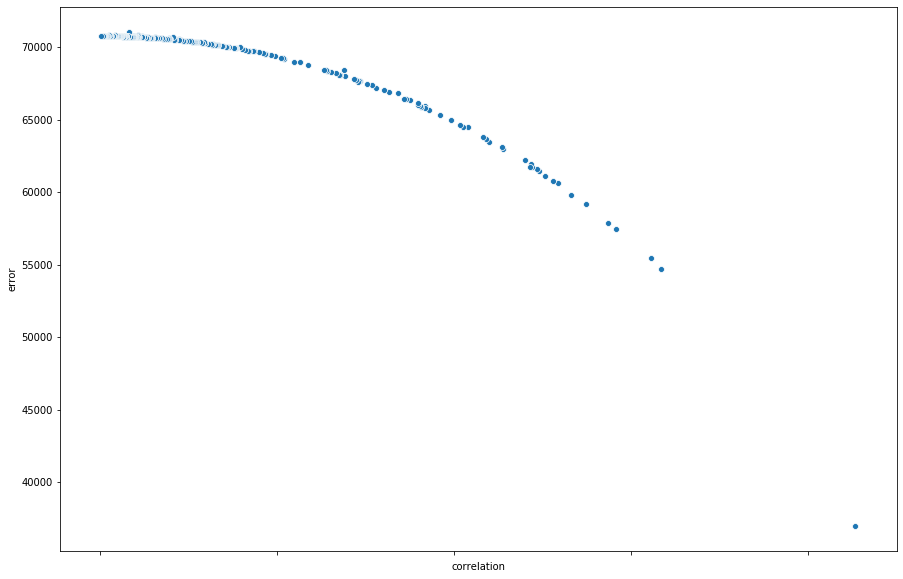

In [78]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=singlevar_regression['correlation'], y=singlevar_regression['error'])
ax.set_xticklabels([])

The graph we got is the graph we would expect: as correlation with "SalePrice" increased in our features, error decreased in our model. More importantly, we now have a list of features that we can sort by their ability to predict "SalePrice" on their own. So, now, we can work our way through that list, adding a feature each time, to figure out which features lead to the least error when combined in a multiple regression.

In [79]:
all_features = singlevar_regression.sort_values('error')['feature'].to_list()

In [80]:
error = []
feature_added = []
num_of_features = []
for x in range(0,(len(all_features))):
    errors_to_avg = []
    feature_added.append(all_features[x])
    num_of_features.append(x+1)
    for y in range(6):
        errors_to_avg.append(train_and_test(dummied_df, features_start=0, features_end=x+1, k=10, seed=y))
    error.append(np.mean(errors_to_avg))

In [81]:
multivar_regression = pd.DataFrame()

multivar_regression['error'] = error
multivar_regression['feature_added'] = feature_added
multivar_regression['num_of_features'] = num_of_features

In [82]:
multivar_regression.sort_values('error')

,error,feature_added,num_of_features
186,1.786115e+04,Yr Sold_2009,187
185,1.786179e+04,Neighborhood_GrnHill,186
174,1.800542e+04,Neighborhood_Mitchel,175
178,1.801001e+04,Garage Cond_Ex,179
179,1.801506e+04,House Style_SLvl,180
...,...,...,...
124,5.682169e+09,Sale Type_WD,125
114,9.318092e+09,Condition 1_Norm,115
202,1.018847e+10,Roof Style_Flat,203
239,1.117647e+10,Bsmt Cond_Ex,240


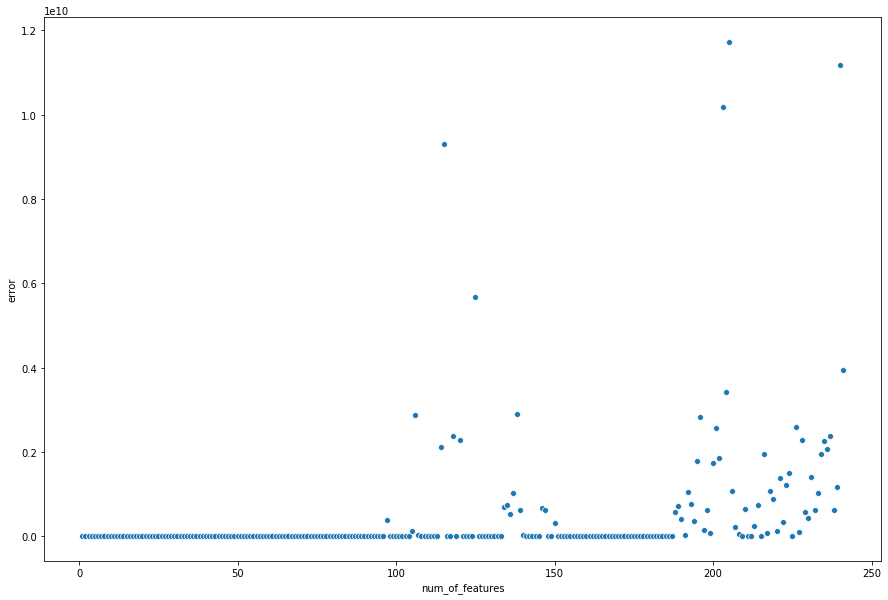

In [83]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=multivar_regression['num_of_features'], y=multivar_regression['error'])

This is a less predictable graph. It seems that up until ~95 features added, we have relatively low rmses, but then error becomes higher and less predictable from there until ~150 features. However, the models with the lowest error are in the 170-190 features range. What's going on here? Can we deduce anything from what features were added when error grew?

In [84]:
#creates a list of all feature names that were added to models where rmse exceeded 40,000.
erratic_features = multivar_regression[multivar_regression['error'] >= 40000]['feature_added'].to_list()

In [85]:
erratic_df = dummied_df[erratic_features]

Perhaps we have some very high homogeneity in our variables. 

In [86]:
feature = []
homogeneity = []
for col in erratic_df:
    homogeneity.append((erratic_df[col].value_counts(normalize=True)*100).sort_values(ascending=False).iloc[0])
    feature.append(col)

In [87]:
erratic_homogeneity = pd.DataFrame()
erratic_homogeneity['feature'] = feature
erratic_homogeneity['homogeneity'] = homogeneity

In [89]:
erratic_homogeneity.sort_values('homogeneity')

,feature,homogeneity
15,Lot Config_Inside,73.145462
64,Yr Sold_2007,76.999586
68,Yr Sold_2008,77.911314
49,Yr Sold_2006,80.812267
45,Mo Sold_6,81.723995
...,...,...
27,Neighborhood_Landmrk,99.958558
28,Kitchen Qual_Po,99.958558
30,Sale Type_VWD,99.958558
31,Sale Type_Oth,99.958558


Of the 75 features that resulted in high-error models, only 3 of them have homogeneity less than 80%. The majority are over 98% homogeneous. This could contribute to why they're throwing off the models. We screened for homogeneity in our features before we dummy-coded. Now we should go back and get rid of anything over 98% homogeneous in our dummy-coded variables.

In [90]:
for col in erratic_df:
    if (erratic_df[col].value_counts(normalize=True)*100).sort_values(ascending=False).iloc[0] > 98:
        all_features.remove(col)

In [91]:
error = []
feature_added = []
num_of_features = []
for x in range(0,(len(all_features))):
    errors_to_avg = []
    feature_added.append(all_features[x])
    num_of_features.append(x+1)
    for y in range(6):
        errors_to_avg.append(train_and_test(dummied_df, features_start=0, features_end=x+1, k=10, seed=y))
    error.append(np.mean(errors_to_avg))

In [92]:
multivar_regression = pd.DataFrame()

multivar_regression['error'] = error
multivar_regression['feature_added'] = feature_added
multivar_regression['num_of_features'] = num_of_features

In [96]:
multivar_regression.sort_values('error')

,error,feature_added,num_of_features
196,1.780447e+04,Lot Config_Corner,197
180,1.781093e+04,Yr Sold_2009,181
198,1.781193e+04,Yr Sold_2007,199
179,1.781516e+04,Neighborhood_GrnHill,180
190,1.782133e+04,Mo Sold_5,191
...,...,...,...
182,2.419499e+09,All Exteriors_Wd Sdng,183
118,3.047014e+09,Exter Cond_TA,119
117,3.048657e+09,Lot Shape_IR2,118
185,4.084352e+09,Mo Sold_9,186


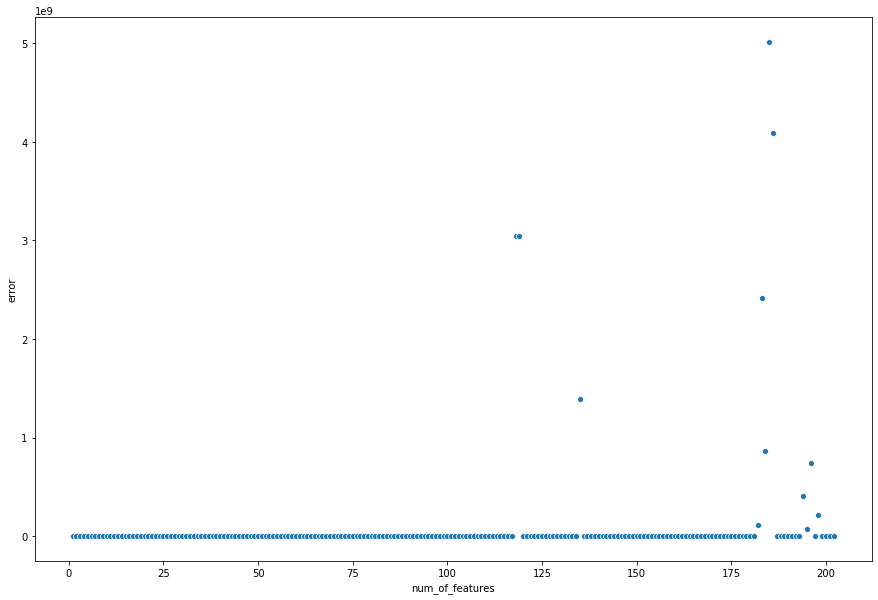

In [94]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=multivar_regression['num_of_features'], y=multivar_regression['error'])

Our list of high-error models has grown shorter. It also seems our lowest error models have gotten a bit better. Which features are associated with higher error now?

In [97]:
multivar_regression.sort_values('error', ascending=False).head(20)

,error,feature_added,num_of_features
184,5.011688e+09,Misc Val,185
185,4.084352e+09,Mo Sold_9,186
117,3.048657e+09,Lot Shape_IR2,118
118,3.047014e+09,Exter Cond_TA,119
182,2.419499e+09,All Exteriors_Wd Sdng,183
134,1.390308e+09,Lot Config_Inside,135
183,8.604188e+08,All Exteriors_Wd Shng,184
195,7.438705e+08,Mo Sold_3,196
193,4.095432e+08,Yr Sold_2010,194
197,2.108857e+08,Mo Sold_2,198


Let's drop the top 13 to see if we can find our lowest-error model. 

In [98]:
high_error_features = multivar_regression.sort_values('error', ascending=False).head(13)['feature_added'].to_list()

In [99]:
for feature in high_error_features:
    all_features.remove(feature)

In [100]:
error = []
feature_added = []
num_of_features = []
for x in range(0,(len(all_features))):
    errors_to_avg = []
    feature_added.append(all_features[x])
    num_of_features.append(x+1)
    for y in range(6):
        errors_to_avg.append(train_and_test(dummied_df, features_start=0, features_end=x+1, k=10, seed=y))
    error.append(np.mean(errors_to_avg))

In [101]:
multivar_regression = pd.DataFrame()

multivar_regression['error'] = error
multivar_regression['feature_added'] = feature_added
multivar_regression['num_of_features'] = num_of_features

In [102]:
multivar_regression.sort_values('error', ascending=False)

,error,feature_added,num_of_features
132,3.014718e+09,All Exteriors_Plywood,133
131,2.652243e+09,Land Slope_Mod,132
0,3.697599e+04,Total SF,1
1,3.527879e+04,Bathrooms,2
2,3.522035e+04,Garage Area,3
...,...,...,...
183,1.778248e+04,Yr Sold_2006,184
184,1.778190e+04,Lot Config_Corner,185
185,1.778115e+04,Yr Sold_2007,186
182,1.777724e+04,Mo Sold_5,183


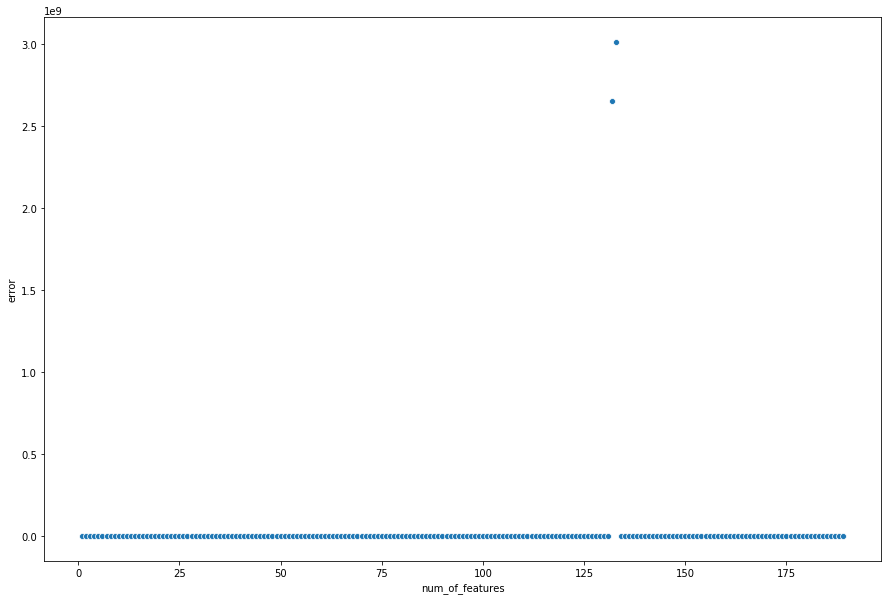

In [103]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=multivar_regression['num_of_features'], y=multivar_regression['error'])

And if we drop "All Exteriors_Plywood" and "Land Slope_Mod"?

In [106]:
all_features.remove('All Exteriors_Plywood')
all_features.remove('Land Slope_Mod')

In [107]:
error = []
feature_added = []
num_of_features = []
for x in range(0,(len(all_features))):
    errors_to_avg = []
    feature_added.append(all_features[x])
    num_of_features.append(x+1)
    for y in range(6):
        errors_to_avg.append(train_and_test(dummied_df, features_start=0, features_end=x+1, k=10, seed=y))
    error.append(np.mean(errors_to_avg))

In [108]:
multivar_regression = pd.DataFrame()

multivar_regression['error'] = error
multivar_regression['feature_added'] = feature_added
multivar_regression['num_of_features'] = num_of_features

In [111]:
multivar_regression.sort_values('error')

,error,feature_added,num_of_features
186,17769.340851,Mo Sold_7,187
180,17771.624820,Mo Sold_5,181
183,17775.118965,Yr Sold_2007,184
182,17775.517886,Lot Config_Corner,183
181,17776.441876,Yr Sold_2006,182
...,...,...,...
4,32867.035368,Exter Qual_TA,5
3,35022.915530,Avg Rm Area AbvGrd,4
2,35220.352606,Garage Area,3
1,35278.785655,Bathrooms,2


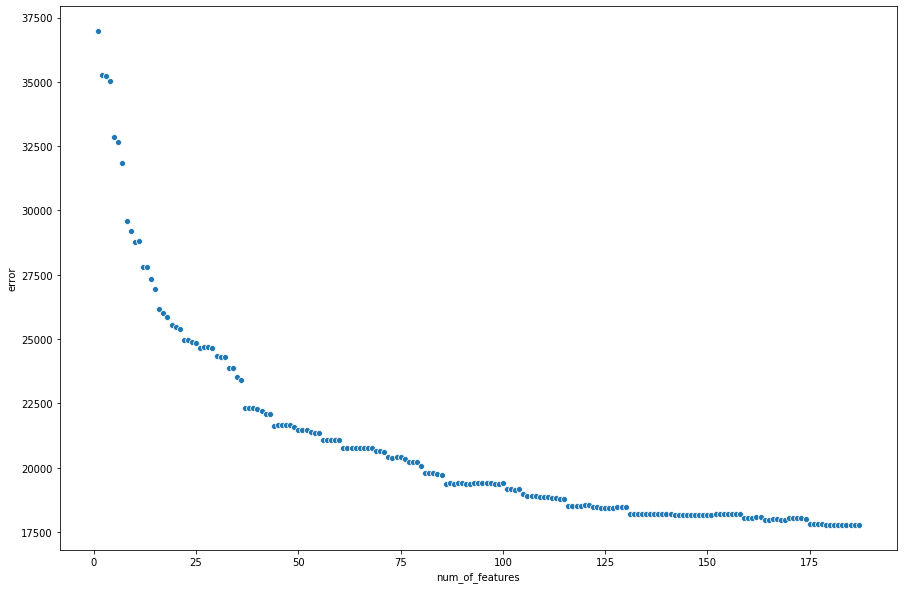

In [110]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x=multivar_regression['num_of_features'], y=multivar_regression['error'])

We get our best model! Error generally decreases with each feature added. This is a good sign we've picked the correct features. We can try cross-validating with a variety of ks to make sure we haven't overfitted.

In [112]:
error = []
feature_added = []
num_of_features = []
k_value = []
for x in range(176,187):
     for k in range(0,11):
            feature_added.append(all_features[x])
            num_of_features.append(x+1)
            k_value.append(k)
            errors_to_avg = []
            for i in range(3):
                errors_to_avg.append(train_and_test(dummied_df, features_start=0, features_end=x+1, k=k, seed=i))
            error.append(np.mean(errors_to_avg))

19299.407939214172 19429.46252846965
17078.381214879602 19311.336792011905
18325.765907334055 18913.135748166314
19290.147908038583 19452.519176975657
17076.32426527208 19312.778810603
18320.12931151512 18894.498272951765
19256.181955704684 19413.31313993538
17122.539624003024 19286.367168060635
18280.727277585174 18858.319667105527
19261.26724934823 19457.81351973785
17128.051856090035 19287.40811632065
18282.736442551683 18859.805003626498
19269.31088422295 19413.68153676147
17138.19888588698 19277.883201748973
18272.37095327589 18832.869452657258
19279.059140836074 19435.469430481684
17163.752107862943 19274.11388049133
18276.168486479415 18840.0702072981
19297.370741241706 19452.270283333615
17159.897311117544 19351.153258589915
18287.614476542065 18846.310333078898
19292.349154505817 19475.39147550588
17139.697328666723 19347.168645366964
18284.245581558906 18835.216574414604
19374.74688017448 19603.0187520736
17139.72652112915 19369.0530984516
18285.898984697877 18903.58016856411

In [113]:
k_selection = pd.DataFrame()

k_selection['error'] = error
k_selection['feature_added'] = feature_added
k_selection['num_of_features'] = num_of_features
k_selection['k_value'] = k_value

In [114]:
k_selection.sort_values('error')

,error,feature_added,num_of_features,k_value
53,17732.042581,Mo Sold_5,181,9
119,17736.535909,Mo Sold_7,187,9
31,17736.734899,Lot Config_FR2,179,9
64,17737.133079,Yr Sold_2006,182,9
86,17738.529603,Yr Sold_2007,184,9
...,...,...,...,...
78,18729.011460,Yr Sold_2007,184,1
67,18732.436067,Lot Config_Corner,183,1
111,18773.747456,Mo Sold_7,187,1
89,18779.337401,Mo Sold_12,185,1


In [118]:
k_selection.groupby(num_of_features)['error'].mean().sort_values()

181    18068.976737
179    18071.977822
182    18075.656646
184    18077.084672
183    18078.659590
180    18080.786676
177    18088.752722
187    18089.793478
178    18098.232597
185    18103.542054
186    18106.545174
Name: error, dtype: float64

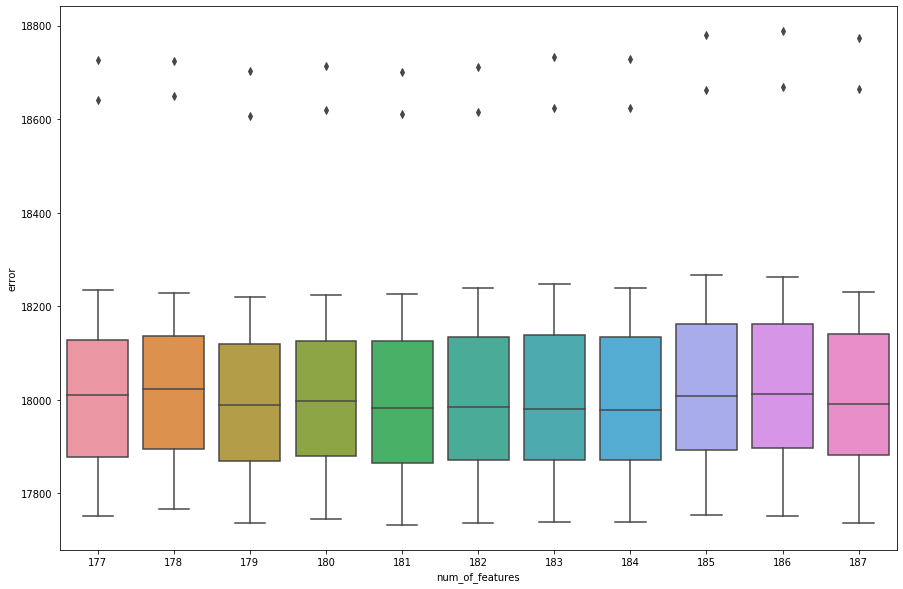

In [115]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(k_selection['num_of_features'], k_selection['error'])

So, when k was 10, we found that using every feature left in our list resulted in the best model. When we iterate through ks for our cross-validation, however, and average across different ks, we find that only the first 181 features lead to the best model. What if we permutate our dataframe a few times?

In [123]:
error = []
feature_added = []
num_of_features = []
for x in range(176,187):
    feature_added.append(all_features[x])
    num_of_features.append(x+1)
    errors_to_avg = []
    for i in range(6,11):
        errors_to_avg.append(train_and_test(dummied_df, features_start=0, features_end=x+1, k=10, seed=i))
    error.append(np.mean(errors_to_avg))

In [124]:
permutation = pd.DataFrame()

permutation['error'] = error
permutation['feature_added'] = feature_added
permutation['num_of_features'] = num_of_features

In [125]:
permutation.sort_values('error')

,error,feature_added,num_of_features
4,17582.026210,Mo Sold_5,181
10,17586.344399,Mo Sold_7,187
5,17587.273817,Yr Sold_2006,182
2,17589.933500,Lot Config_FR2,179
6,17590.290100,Lot Config_Corner,183
7,17590.584765,Yr Sold_2007,184
3,17601.439414,Mo Sold_6,180
9,17603.066153,Yr Sold_2008,186
8,17608.699896,Mo Sold_12,185
1,17625.013804,Mo Sold_1,178


Here again, it seems 181 features has a slight edge over all 187.

In [148]:
all_features = all_features[:181]

So our final list of features is:

In [149]:
all_features

['Total SF',
 'Bathrooms',
 'Garage Area',
 'Avg Rm Area AbvGrd',
 'Exter Qual_TA',
 'Full Bath',
 'Sale Age',
 'Bsmt Qual_Ex',
 'Kitchen Qual_TA',
 'Sale Remod/Add Age',
 'Foundation_PConc',
 'Fireplaces',
 'Sale Garage Age',
 'Exter Qual_Gd',
 'Mas Vnr Area',
 'Kitchen Qual_Ex',
 'All BsmtFin Types_GLQ',
 'BsmtFin SF 1',
 'Overall Qual_8',
 'Bsmt Qual_TA',
 'Heating QC_Ex',
 'Exter Qual_Ex',
 'Garage Finish_Unf',
 'Overall Qual_9',
 'Garage Finish_Fin',
 'Mas Vnr Type_None',
 'Neighborhood_NridgHt',
 'Garage Type_Detchd',
 'Kitchen Qual_Gd',
 'Bsmt Exposure_Gd',
 'Overall Qual_5',
 'Garage Type_Attchd',
 'Neighborhood_NoRidge',
 'Wood Deck SF',
 'Lot Frontage',
 'Overall Cond_5',
 'Overall Qual_10',
 'Open Porch SF',
 'Foundation_CBlock',
 'Heating QC_TA',
 'Lot Shape_Reg',
 'MS Zoning_RM',
 'Bsmt Qual_Gd',
 '2nd Flr SF',
 'Half Bath',
 'Mas Vnr Type_BrkFace',
 'Bsmt Full Bath',
 'Lot Shape_IR1',
 'Garage Cond_TA',
 'Overall Qual_4',
 'Paved Drive_Y',
 'Bsmt Exposure_No',
 'Central A

We can check perform one final check for overfitting by comparing our in-sample vs. cross-validated error.

In [150]:
def overfit_test(df, features, target):
    lr = LinearRegression()
    np.random.seed(10)
    df = df.iloc[np.random.permutation(len(df))]
    train = df[:1460]
    test = df[1460:]

    lr.fit(df[features], df[target])
    predictions = lr.predict(df[features])
    rmse1 = (mean_squared_error(df[target], predictions))**0.5
    print("in-sample error: " + str(rmse1))
    rmse2 = train_and_test(dummied_df, features_start=0, features_end=x+1, k=10, seed=10)
    print("10-fold cross-validation error: " + str(rmse2))
    return rmse1, rmse2

In [151]:
overfit_test(dummied_df, all_features, 'SalePrice')

in-sample error: 15844.764695275016
10-fold cross-validation error: 17521.71803637372


(15844.764695275016, 17521.71803637372)

We have less than a couple of thousand dollars worth of difference, which is relatively small given the large numbers we are working with. It looks as if our model will be generalizable.